# Librerie e funzioni d'utilità

In [1]:
import os
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors

import pandas as pd
import random
import string

%matplotlib inline

In [2]:
blu_fiordaliso = "#6495ED"
lilla = "#c8a2c8"
nero = "#000000"
gradient = ["#ffffff", "#dcc4dc","#c8a2c8", "#a787ad", "#93779c", "#735d82", "#6c4675"]
my_cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", gradient)

In [3]:
matrix = np.array([[149030, 34],[7442, 12]])
norm = matplotlib.colors.Normalize(matrix.min(), matrix.max())
boundaries = [value for value in matrix.flatten().tolist()]
list.sort(boundaries)
colors = [[norm(boundaries[0]), "#dcc4dc"], 
          [norm(boundaries[1]), "#c8a2c8"], 
          [norm(boundaries[2]), "#93779c"], 
          [norm(boundaries[3]), "#6c4675"]]
my_cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

In [4]:
directory_dataset = ".\\mitdb"

In [5]:
# create directory "mitdb" and download dataset
if not os.path.exists(directory_dataset):
    os.mkdir(directory_dataset)
    wfdb.dl_database("mitdb", directory_dataset)

# wf.io.show_ann_classes()
# wf.io.show_ann_labels()

In [6]:
wf.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

# Data profiling

In [7]:
# extract filename from directory
list_of_file = list(set([x.rsplit('.', 1)[0] for x in os.listdir(directory_dataset)]))
list_of_file.sort()

In [8]:
# key = filename, value = [record(tuple), annotation(array)]
dataset = {}

for filename in list_of_file:
    file = os.path.join(directory_dataset, filename)
    
    # read the file
    record = wf.rdsamp(file)
    annotation = wf.rdann(file, 'atr')
    dataset[filename] = [record, annotation]
    
    # info about the data
    print("File:", file)
    print("Sampling frequency:", record[1].get("fs"))
    print("Data shape:", record[0].shape)
    print("Annotations:", len(annotation.num))
    print("\n")

File: .\mitdb\100
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2274


File: .\mitdb\101
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1874


File: .\mitdb\102
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2192


File: .\mitdb\103
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2091


File: .\mitdb\104
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2311


File: .\mitdb\105
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2691


File: .\mitdb\106
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2098


File: .\mitdb\107
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2140


File: .\mitdb\108
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1824


File: .\mitdb\109
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2535


File: .\mitdb\111
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2133


File: .\mitdb\112
Sampling frequency: 360
Data shape: 

In [9]:
# plot bar chart esteso
def bar_plot_ex(keys, values, title, path, dim):
    plt.figure(figsize=dim) 
    plt.yscale("log")
    plt.grid(color=nero, linestyle='-', linewidth=0.5, axis="y")
    plt.title(title)
    p = plt.bar(keys, values, width=1, color=lilla, edgecolor=nero, linewidth=0.5, align='center')
    plt.xticks(rotation = 90)
    plt.savefig(path, bbox_inches='tight', transparent=True)
    plt.show()

In [10]:
# distribution of annotation
labels = {}
for record in dataset.values():
    annotypes = np.array(record[1].symbol)
    for label in annotypes:
        if label in labels.keys():
            labels[label] += 1
        else:
            labels[label] = 1
labels = dict(sorted(labels.items(), key=lambda item: item[1], reverse=True))

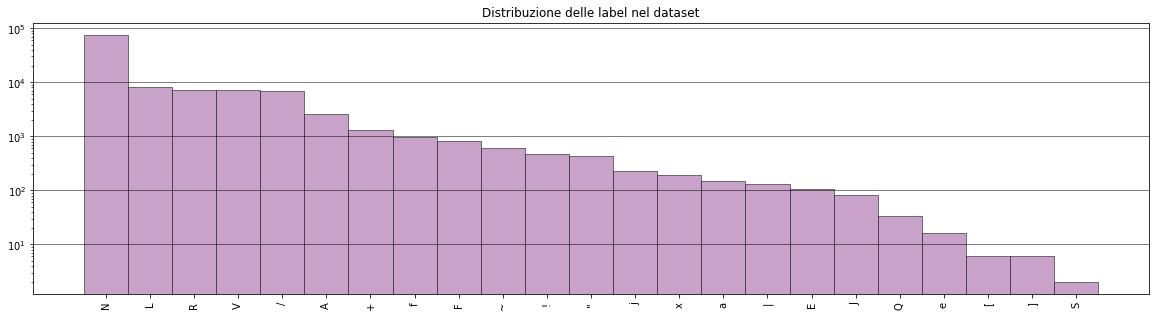

In [11]:
keys = labels.keys()
values = [item for item in labels.values()]
title = "Distribuzione delle label nel dataset"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (20,5)
bar_plot_ex(keys, values, title, file_name, dim)

In [12]:
tmp = {}
for key, record in dataset.items():
    annotypes = np.array(record[1].symbol)
    tmp[key] = dict.fromkeys(labels.keys(), 0)
    for label in annotypes:
        tmp[key][label] = tmp[key][label] + 1

df = pd.DataFrame.from_dict(tmp)
df = df.replace(0, np.nan)
df = df.T

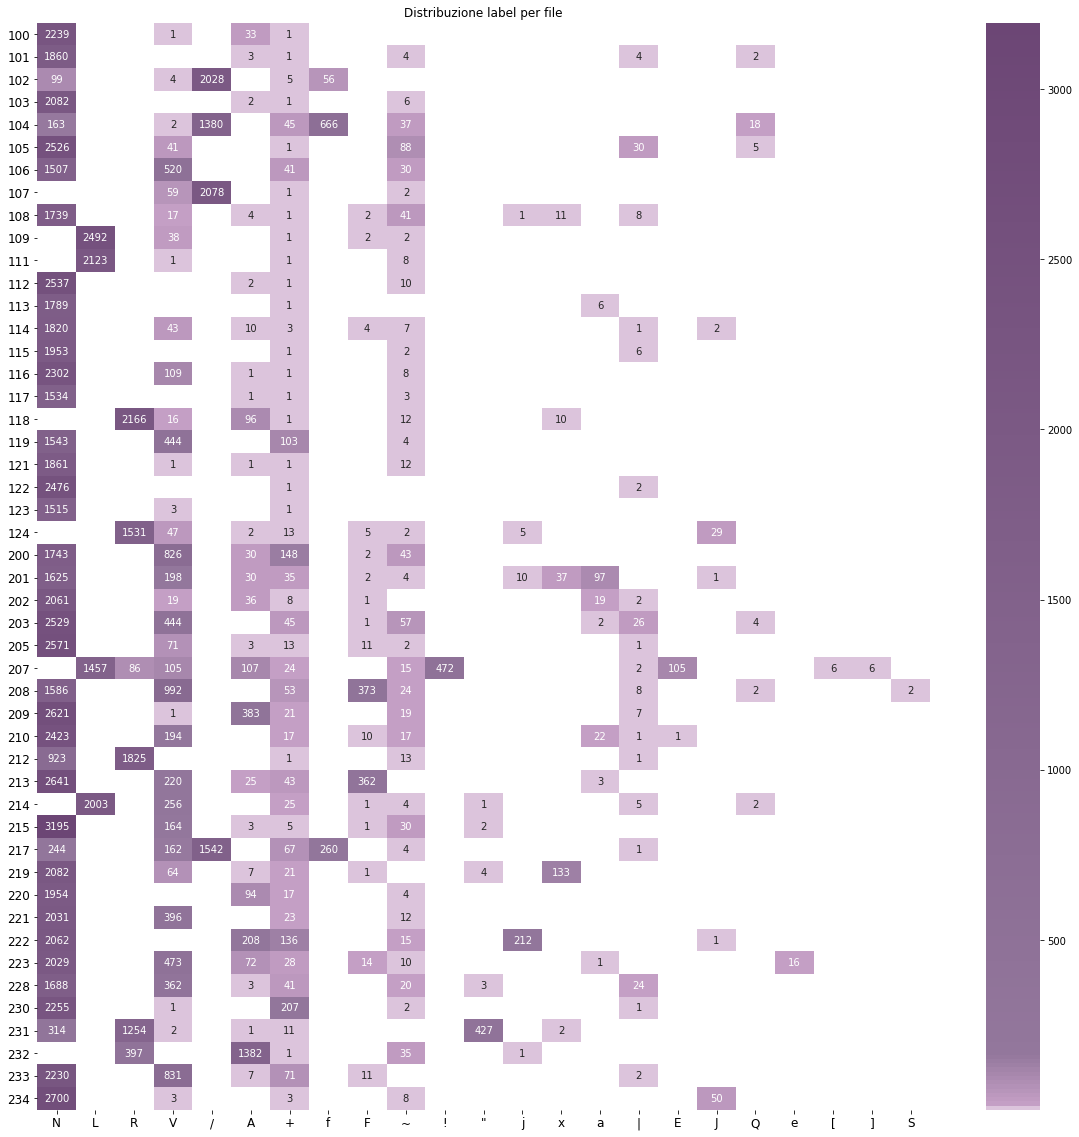

In [13]:
fig, ax = plt.subplots(figsize=(20,20)) 
title = "Distribuzione label per file"
file_name = "".join(title.lower()).replace(" ", "_")
ax.set_title(title)
ax.set_xlabel("Label")
ax.set_ylabel("File")
heatmap = sns.heatmap(df, ax=ax, annot=True, fmt=".0f", cmap=my_cmap2)
a = heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0, fontsize = 12)
b = heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 0, fontsize = 12)
fig.savefig(file_name, bbox_inches='tight', transparent=True)

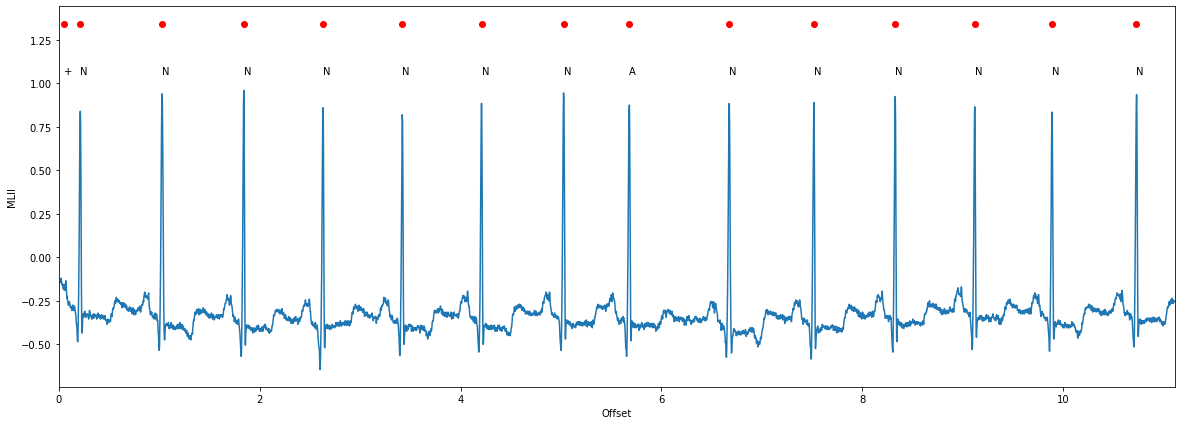

In [18]:
# there are 2 channels -> MLII wave = 0
channel = 0             

# start of the sample in the file
sample_start = 0        

# number of readings (360 per second)
sample_size = 4000      

record = dataset["100"][0]
annotation = dataset["100"][1]

# get data and annotations for the samples selected below
sample_end = sample_start + sample_size
signal = record[0][sample_start:sample_end, channel]

# plot the heart beats
# time scale is number of readings divided by sampling frequency
times = (np.arange(sample_size, dtype = 'float') + sample_start) / record[1].get('fs')
plt.figure(figsize=(20,7))
plt.plot(times, signal)

# extract annotations
where = np.logical_and(annotation.sample >= sample_start, annotation.sample < sample_end)
annots = annotation.sample[where] - sample_start
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# plot the annotations
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * signal.max() * 1.4, 'ro')

# snnotation codes
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], signal.max() * 1.1))

plt.xlim([sample_start / record[1].get('fs'), (sample_end / record[1].get('fs'))])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[channel])
plt.show()